In [1]:
import os
import cv2
import time
import functools
import skimage.io
import numpy as np
import skimage.filters
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from tensorflow.keras import Model
from skimage.transform import resize
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, add

import tensorflow.python.ops.numpy_ops.np_config as np_config
np_config.enable_numpy_behavior()

In [82]:
def data_generator(sequences_path, batch_size, scale_factor):
    sequences_names = os.listdir(sequences_path)
    sequences_count = len(sequences_names)
    batches_count = sequences_count // batch_size
    selected_random_batches = np.random.choice(sequences_names, (batches_count, batch_size), replace=True)
    sequence_len = 7
    
    # Now lets loop over the full epoch and process each batch befor return it to the network
    for batch in selected_random_batches:
        GT_batch = []
        LR_batch = []
        for sequence in batch:
            for f_index in range(sequence_len):
                img_path = sequences_path + str(sequence) + '/' + str(f_index)
                GT_rgb_img = skimage.io.imread(img_path + '_HR.jpg')
                Blurred_rgb_img = skimage.io.imread(img_path + '_Blurred.jpg')
                h,w,_ = Blurred_rgb_img.shape
                h, w = h//scale_factor, w//scale_factor
                LR_rgb_img = tf.image.resize(Blurred_rgb_img, (h,w))
                GT_batch.append(GT_rgb_img)
                LR_batch.append(LR_rgb_img)

        _, GT_frame_H, GT_frame_W, frame_C = np.array(GT_batch).shape
        _, LR_frame_H, LR_frame_W, frame_C = np.array(LR_batch).shape

        GT_batch = np.array(GT_batch).reshape(batch_size, sequence_len, GT_frame_H, GT_frame_W, frame_C)
        LR_batch = np.array(LR_batch).reshape(batch_size, sequence_len, LR_frame_H, LR_frame_W, frame_C)


        yield GT_batch, LR_batch, batches_count

In [3]:
# Concatenate the Residual Blocks
def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return tf.keras.Sequential(layers)

In [4]:
# Residual Blocks 
class Residual_Blocks(tf.keras.Model):
    '''Residual block w/o BN
    -+-Conv-ReLU-Conv-+-
     |________________|
    '''
    def __init__(self, n_f):
        super(Residual_Blocks, self).__init__()
        self.conv1 = Conv2D(filters=n_f, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())
        self.conv2 = Conv2D(filters=n_f, kernel_size=(3,3), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        
    def call(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        return out + identity

In [5]:
# Hidden layers of the network
class hidden(tf.keras.Model):
    def __init__(self, n_f, n_b, scale):
        super(hidden, self).__init__()
        self.conv1 = Conv2D(filters=n_f, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        basic_block = functools.partial(Residual_Blocks, n_f=n_f)
        self.residual_blocks = make_layer(basic_block, n_b)
        self.conv_h = Conv2D(filters=n_f, kernel_size=(3,3), activation='relu', padding='same', name='hidden_state', kernel_initializer=tf.keras.initializers.HeNormal())
        self.conv_o = Conv2D(filters=scale*scale*3, kernel_size=(3,3), padding='same', name='output', kernel_initializer=tf.keras.initializers.HeNormal())
        
    def call(self, X, h, o):
        x_input = tf.concat([X, tf.cast(h, tf.float32), tf.cast(o, tf.float32)], axis=-1)
        x = self.conv1(x_input)
        x = self.residual_blocks(x)
        x_h = self.conv_h(x)
        x_o = self.conv_o(x)
        return x_h, x_o

In [6]:
# Down smaple the input
class PixelUnShuffle(tf.keras.Model):
    def __init__(self, scale):
        super(PixelUnShuffle, self).__init__()
        self.scale_factor = scale
    
    def call(self, x_o):
        x_o = tf.nn.space_to_depth(x_o, self.scale_factor)
        return x_o

In [84]:
# Main class
class RRN(tf.keras.Model):
    def __init__(self, n_f, n_b, scale):
        super(RRN, self).__init__()
        self.hidden = hidden(n_f, n_b, scale)
        self.scale = scale
        self.down = PixelUnShuffle(scale)
        self.n_f = n_f
        
    def call(self, x, x_h, x_o, init):
        f1 = x[:,0,:,:,:]
        f2 = x[:,1,:,:,:]
        h,w = f1.shape[1:3]
        x_input = tf.concat([f1, f2], axis=-1)
        if init:
            x_h, x_o = self.hidden(x_input, x_h, x_o)
        else:
            x_o = self.down(x_o)
            x_h, x_o = self.hidden(x_input, x_h, x_o)
        
        x_o = tf.image.resize(f2, (h*self.scale, w*self.scale)) + tf.nn.depth_to_space(x_o, self.scale)
        return x_h, x_o
    
    def train(self, data_generator, epochs, batch_size, loss_fn, optimizer):
        # train the model using that batches sample
        # model.load_weights('check_points/model_weights')

        for epoch in range(epochs):
            train_data = data_generator
            
            for batch_index, (HR, LR, batches_count) in enumerate(train_data):
                t0 = time.time()
                _,frames_count,H,W,_ = HR.shape

                sequences_per_batch_loss = np.zeros([batch_size, H, W])
                output = np.empty_like(HR)

                for frame_index in range(frames_count):
                    if not bool(frame_index):
                        # Initialize frame[-1], hidden_state[-1] and prediction[-1]
                        x_input = tf.concat([tf.zeros_like(LR[:,0:1,:,:,:]), LR[:,0:1,:,:,:]], axis=1)
                        init_frame = tf.zeros_like(LR[:,0,:,:,:])
                        prediction = tf.repeat(init_frame, repeats=4**2, axis=3)
                        hidden_state = tf.repeat(init_frame[:,:,:,:1], repeats=64, axis=-1)
                    else:
                        x_input = LR[:,frame_index-1:frame_index+1,:,:,:]

                    with tf.GradientTape() as tape:
                        hidden_state, prediction = self(x_input, hidden_state, prediction, not bool(frame_index))
                        loss_value = loss_fn(HR[:,frame_index], prediction)
                        gradients = tape.gradient(loss_value, model.trainable_variables)
                    sequences_per_batch_loss+=loss_value
                    optimizer.apply_gradients([
                        (grad, var) 
                        for (grad, var) in zip(gradients, model.trainable_variables) 
                        if grad is not None
                    ])
                    output[:,frame_index] = prediction
                t1 = time.time()
                # model.save_weights('check_points/model_weights')   

                fig, axs = plt.subplots(1, 2, figsize=(15, 15))
                axs[0].imshow(tf.cast(HR[0,0], tf.uint8))
                axs[0].title.set_text('Ground Truth')
                axs[1].imshow(tf.cast(output[0,0], tf.uint8))
                axs[1].title.set_text('Network output')
                plt.show()

                print("====>Epoch[{}],({}/{}): Sequences_Loss: {:.4f} || Timer: {:.4f} sec.".
                format(epoch, (batch_index+1),batches_count, tf.reduce_mean(sequences_per_batch_loss), (t1-t0)))

In [27]:
# Enviroment variables
epochs = 2
batch_size = 64
sigma = 1.6
kernal_size = 64
scale_factor = 4
n_f = 64
n_b = 4
GT_path = '360p/sequences/'

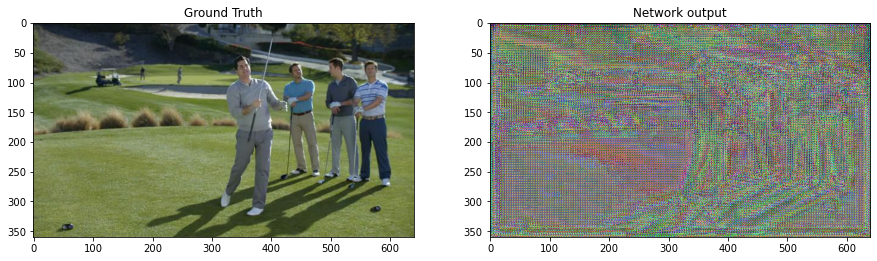

====>Epoch[0],(1/96): Sequences_Loss: 8395083.9926 || Timer: 22.2598 sec.


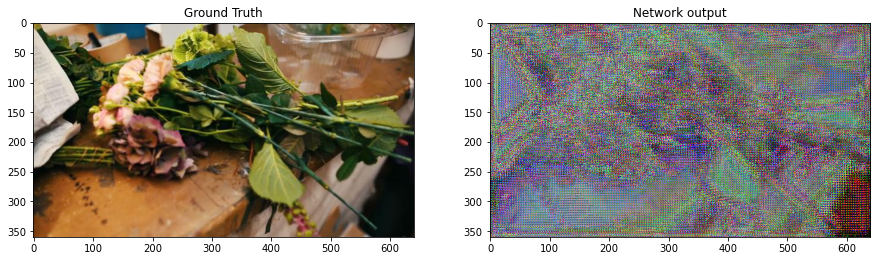

====>Epoch[0],(2/96): Sequences_Loss: 2139383.7570 || Timer: 16.6486 sec.


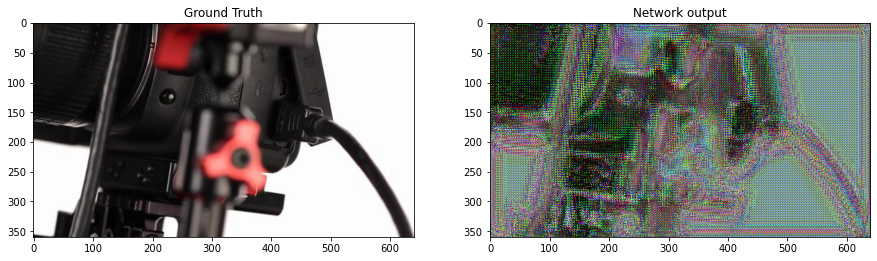

====>Epoch[0],(3/96): Sequences_Loss: 741069.6004 || Timer: 16.7366 sec.


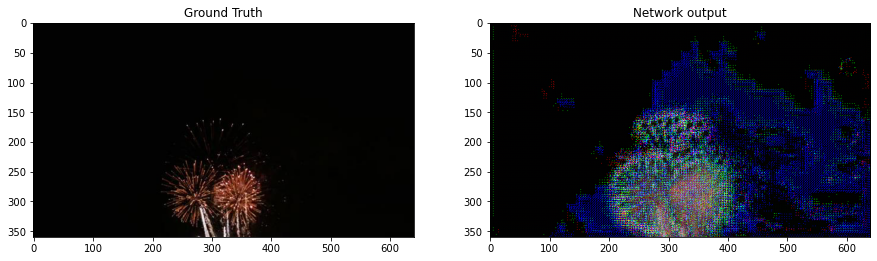

====>Epoch[0],(4/96): Sequences_Loss: 351277.3804 || Timer: 16.7096 sec.


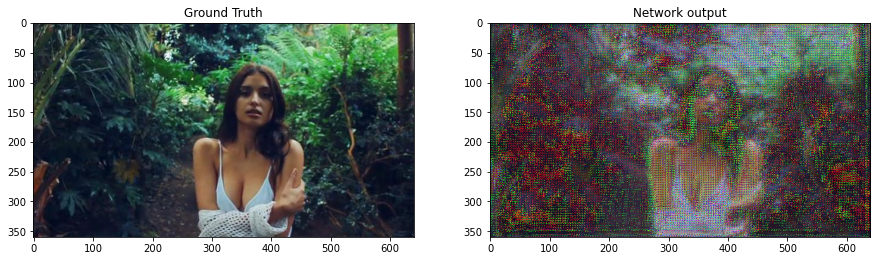

====>Epoch[0],(5/96): Sequences_Loss: 272828.0856 || Timer: 17.1345 sec.


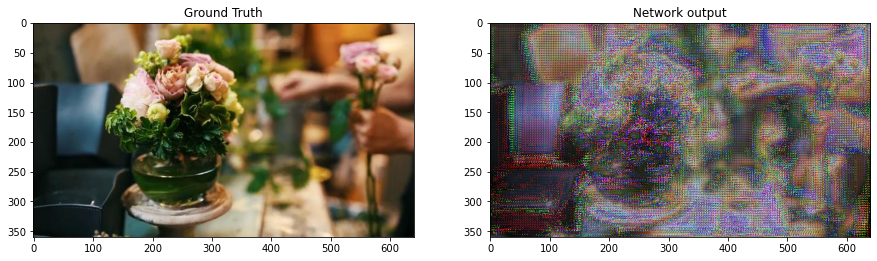

====>Epoch[0],(6/96): Sequences_Loss: 232957.4427 || Timer: 16.3479 sec.


KeyboardInterrupt: 

In [85]:
loss_fn = tf.keras.losses.mae
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model = RRN(n_f, n_b, scale_factor)
data_gen = data_generator(GT_path, batch_size, scale_factor)
model.train(data_gen, epochs, batch_size, loss_fn, optimizer)